# Plot the emotions using the sliding window evaluation

In [24]:
import matplotlib.pyplot as plt
import glob
import pandas as pd
import pickle
import numpy as np

emotions = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'neutral', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise']
chosen_difference_emotions = ["Admiration", "Anger", "Approval", "Confusion", "Curiosity", "Excitement", "Gratitude", "Joy", "Neutral", "Sadness"]


# Full aggregate per emotion

Score vector lengths: [103, 128, 144, 326, 133, 507, 116, 213, 354, 550, 141, 103, 113, 94, 102, 268, 58, 91, 316]
Shortest score vector: 58
n_values (100) is longer than the shortest score vector (58), setting n_values to 58


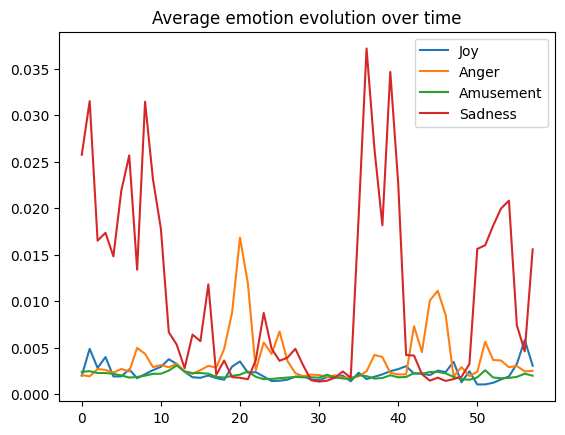

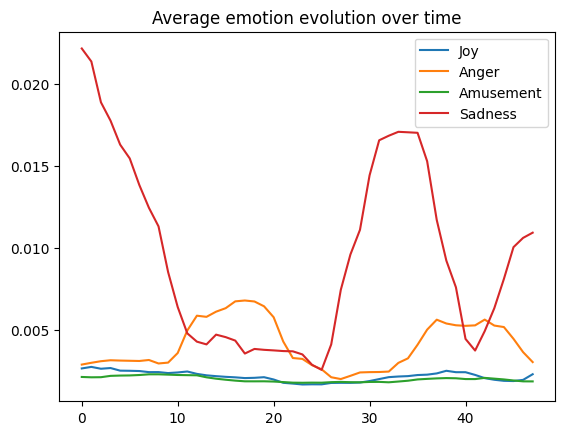

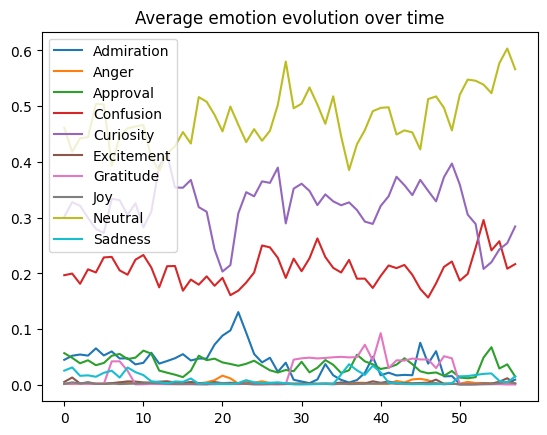

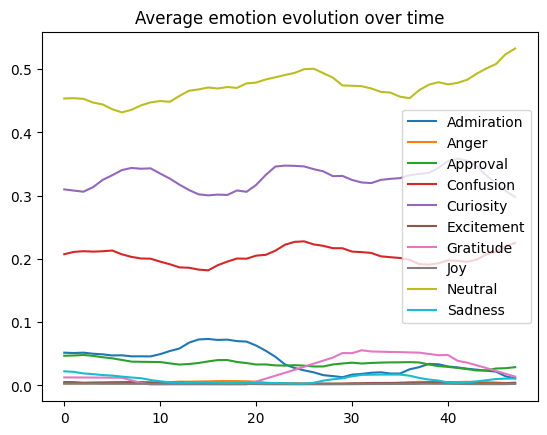

In [32]:

# Plot full aggregate of emotions per emotion

score_filenames = glob.glob("data/results/*_roberta_wordwindow10_scores.pkl")

lens = []
for score_filename in score_filenames:
    with open(score_filename, 'rb') as f:
        scores = pickle.load(f)
        lens.append(len(scores["middle"]))

min_length = min(lens)
print(f"Score vector lengths: {lens}")
print(f"Shortest score vector: {min_length}")


# For each session, we map the scores to a fixed length

n_values = 100
if n_values > min_length:
    print(f"n_values ({n_values}) is longer than the shortest score vector ({min_length}), setting n_values to {min_length}")
    n_values = min_length
    
def map_to_fixed_length(scores, n_values):
    
    scores_per_value = len(scores) // n_values
    fixed_scores = [np.mean(scores[i*scores_per_value:(i+1)*scores_per_value], axis=0) for i in range(n_values)]
    fixed_scores = np.array(fixed_scores)
    return fixed_scores



emotions = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'neutral', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise']
aggregated_scores = {
    "intro": np.zeros(28),
    "outro": np.zeros(28),
    "middle": np.zeros((n_values, 28)),
}

for score_filename in score_filenames:
    with open(score_filename, 'rb') as f:
        scores = pickle.load(f)

    scores["middle"] = map_to_fixed_length(scores["middle"], n_values)

    aggregated_scores["intro"] += scores["intro"]
    aggregated_scores["outro"] += scores["outro"]
    aggregated_scores["middle"] += scores["middle"]

aggregated_scores = {k: v / len(score_filenames) for k, v in aggregated_scores.items()}

# Smoothen the aggregated scores with numpy
smoothing_window = 10
smooth_aggregated_scores = {
    k: np.apply_along_axis(lambda m: np.convolve(m, np.ones(smoothing_window)/smoothing_window, mode='same'), 0, v)[smoothing_window//2:-smoothing_window//2]
    for k, v in aggregated_scores.items()
    }
#print(aggregated_scores)

plt.figure()
plt.title(f"Average emotion evolution over time")
for emotion in ["joy", "anger", "amusement", "sadness"]:
    plt.plot(aggregated_scores["middle"][:, emotions.index(emotion)], label=f"{emotion.capitalize()}")
plt.legend()
plt.savefig("data/results/plots/roberta_wordwindow10_all.png")
plt.show()

plt.figure()
plt.title(f"Average emotion evolution over time")
for emotion in ["joy", "anger", "amusement", "sadness"]:
    plt.plot(smooth_aggregated_scores["middle"][:, emotions.index(emotion)], label=f"{emotion.capitalize()}")
plt.legend()
plt.savefig("data/results/plots/roberta_wordwindow10_all_smoothed.png")
plt.show()

plt.figure()
plt.title(f"Average emotion evolution over time")
for emotion in chosen_difference_emotions:
    plt.plot(aggregated_scores["middle"][:, emotions.index(emotion.lower())], label=f"{emotion.capitalize()}")
plt.legend()
plt.savefig("data/results/plots/roberta_wordwindow10_chosen.png")
plt.show()

plt.figure()
plt.title(f"Average emotion evolution over time")
for emotion in chosen_difference_emotions:
    plt.plot(smooth_aggregated_scores["middle"][:, emotions.index(emotion.lower())], label=f"{emotion.capitalize()}")
plt.legend()
plt.savefig("data/results/plots/roberta_wordwindow10_chosen_smoothed.png")
plt.show()


In [26]:
import seaborn as sns
from IPython.display import display
def compute_tables(aggregated_scores, title_prefix=""):
    emotion_average = {
        "Intro": aggregated_scores["intro"],
        "Gameplay": np.mean(aggregated_scores["middle"], axis=0),
        "Outro": aggregated_scores["outro"],
        "Total impact": aggregated_scores["outro"] - aggregated_scores["intro"],
        "Gameplay impact": np.mean(aggregated_scores["middle"], axis=0) - aggregated_scores["intro"],
        "Outro impact": aggregated_scores["outro"] - np.mean(aggregated_scores["middle"], axis=0),
    }
    df = pd.DataFrame.from_dict(emotion_average) * 100
    df.index = [e.capitalize() for e in emotions]
    pd.set_option('display.float_format', '{:.1f}'.format)
    display(df)

    style_cmap_diverging = 'vlag'
    style_cmap_sequential = 'Blues'

    full_scores_hm = df.style.background_gradient(cmap=style_cmap_diverging)
    display(full_scores_hm)

    with open(f"data/results/{title_prefix}full_scores.html", "w") as f:
        f.write(full_scores_hm.to_html())

    section_scores = df[["Intro", "Gameplay", "Outro"]]
    section_scores_hm = section_scores.style.background_gradient(cmap=style_cmap_sequential)
    html = section_scores_hm.to_html()

    with open(f"data/results/{title_prefix}section_scores.html", "w") as f:
        f.write(html)
    display(section_scores_hm)

    difference_scores = df[["Total impact", "Gameplay impact", "Outro impact"]]
    difference_scores_hm = difference_scores.style.background_gradient(cmap=style_cmap_diverging)
    display(difference_scores_hm)

    with open(f"data/results/{title_prefix}difference_scores.html", "w") as f:
        f.write(difference_scores_hm.to_html())

    chosen_section_emotions = ["Admiration", "Anger", "Approval", "Confusion", "Curiosity", "Excitement", "Gratitude", "Joy", "Neutral", "Sadness"]
    section_scores_chosen = section_scores.filter(items=chosen_section_emotions, axis=0)
    section_scores_chosen_hm = section_scores_chosen.style.background_gradient(cmap=style_cmap_sequential)
    display(section_scores_chosen_hm)

    with open(f"data/results/{title_prefix}section_scores_chosen.html", "w") as f:
        f.write(section_scores_chosen_hm.to_html())

    chosen_difference_emotions = ["Admiration", "Anger", "Approval", "Confusion", "Curiosity", "Excitement", "Gratitude", "Joy", "Neutral", "Sadness"]
    difference_scores_chosen = difference_scores.filter(items=chosen_difference_emotions, axis=0)
    difference_scores_chosen_hm = difference_scores_chosen.style.background_gradient(cmap=style_cmap_diverging)
    display(difference_scores_chosen_hm)

    with open(f"data/results/{title_prefix}difference_scores_chosen.html", "w") as f:
        f.write(difference_scores_chosen_hm.to_html())
compute_tables(aggregated_scores)

,Intro,Gameplay,Outro,Total impact,Gameplay impact,Outro impact
Admiration,5.4,3.7,5.1,-0.3,-1.7,1.4
Amusement,0.5,0.2,0.5,-0.0,-0.3,0.3
Anger,0.2,0.4,0.4,0.2,0.2,-0.0
Annoyance,0.7,1.5,3.3,2.5,0.7,1.8
Approval,15.4,3.5,10.1,-5.4,-11.9,6.5
Caring,1.1,0.4,0.6,-0.5,-0.7,0.2
Confusion,5.2,20.7,14.3,9.1,15.5,-6.4
Curiosity,17.1,32.0,7.5,-9.6,15.0,-24.6
Desire,0.6,0.3,2.4,1.9,-0.3,2.1
Disappointment,0.3,1.0,4.3,4.0,0.7,3.3


,Intro,Gameplay,Outro,Total impact,Gameplay impact,Outro impact
Admiration,5.424337,3.681983,5.089624,-0.334713,-1.742354,1.407641
Amusement,0.498036,0.200195,0.494729,-0.003307,-0.297841,0.294534
Anger,0.180017,0.388352,0.381664,0.201648,0.208335,-0.006687
Annoyance,0.737572,1.461957,3.264485,2.526913,0.724385,1.802527
Approval,15.445628,3.544481,10.085516,-5.360112,-11.901147,6.541036
Caring,1.118848,0.432817,0.596438,-0.522410,-0.686030,0.163620
Confusion,5.196175,20.738831,14.300590,9.104415,15.542656,-6.438241
Curiosity,17.067519,32.030283,7.456618,-9.610900,14.962765,-24.573665
Desire,0.557233,0.270260,2.409391,1.852158,-0.286973,2.139130
Disappointment,0.306033,0.970552,4.265958,3.959925,0.664519,3.295405


,Intro,Gameplay,Outro
Admiration,5.424337,3.681983,5.089624
Amusement,0.498036,0.200195,0.494729
Anger,0.180017,0.388352,0.381664
Annoyance,0.737572,1.461957,3.264485
Approval,15.445628,3.544481,10.085516
Caring,1.118848,0.432817,0.596438
Confusion,5.196175,20.738831,14.300590
Curiosity,17.067519,32.030283,7.456618
Desire,0.557233,0.270260,2.409391
Disappointment,0.306033,0.970552,4.265958


,Total impact,Gameplay impact,Outro impact
Admiration,-0.334713,-1.742354,1.407641
Amusement,-0.003307,-0.297841,0.294534
Anger,0.201648,0.208335,-0.006687
Annoyance,2.526913,0.724385,1.802527
Approval,-5.360112,-11.901147,6.541036
Caring,-0.522410,-0.686030,0.163620
Confusion,9.104415,15.542656,-6.438241
Curiosity,-9.610900,14.962765,-24.573665
Desire,1.852158,-0.286973,2.139130
Disappointment,3.959925,0.664519,3.295405


,Intro,Gameplay,Outro
Admiration,5.424337,3.681983,5.089624
Anger,0.180017,0.388352,0.381664
Approval,15.445628,3.544481,10.085516
Confusion,5.196175,20.738831,14.300590
Curiosity,17.067519,32.030283,7.456618
Excitement,4.400262,0.405736,0.639686
Gratitude,2.760968,2.067410,2.723970
Joy,4.009852,0.227777,1.593630
Neutral,37.390913,47.829248,41.681442
Sadness,0.174137,1.085536,3.188128


,Total impact,Gameplay impact,Outro impact
Admiration,-0.334713,-1.742354,1.407641
Anger,0.201648,0.208335,-0.006687
Approval,-5.360112,-11.901147,6.541036
Confusion,9.104415,15.542656,-6.438241
Curiosity,-9.610900,14.962765,-24.573665
Excitement,-3.760577,-3.994526,0.233950
Gratitude,-0.036998,-0.693557,0.656560
Joy,-2.416222,-3.782075,1.365853
Neutral,4.290529,10.438335,-6.147805
Sadness,3.013991,0.911400,2.102591


# Plot emotion per interacting NPC

In [27]:
def compute_score_aggregate(files):
    aggregated_scores = {
        "intro": np.zeros(28),
        "outro": np.zeros(28),
        "middle": np.zeros((n_values, 28)),
    }
    for score_filename in files:
        with open(score_filename, 'rb') as f:
            scores = pickle.load(f)
        
        scores["middle"] = map_to_fixed_length(scores["middle"], n_values)

        aggregated_scores["intro"] += scores["intro"]
        aggregated_scores["outro"] += scores["outro"]
        aggregated_scores["middle"] += scores["middle"]

    aggregated_scores = {k: v / len(files) for k, v in aggregated_scores.items()}
    return aggregated_scores

Detected the following NPC emotions: ['neutral', 'sad', 'angry', 'happy']


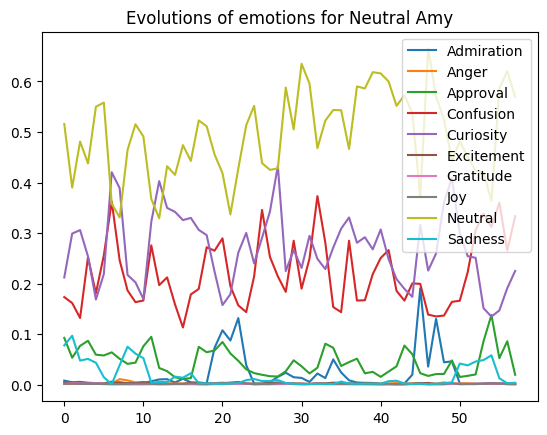

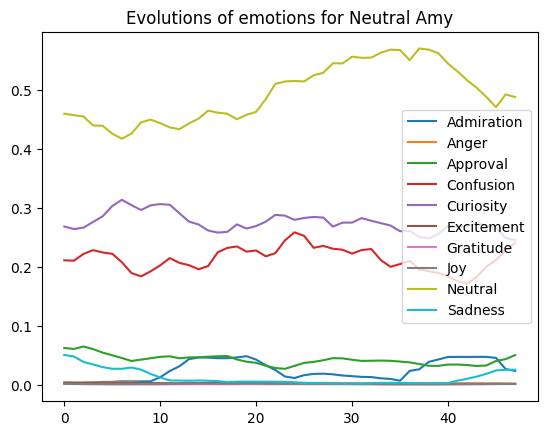

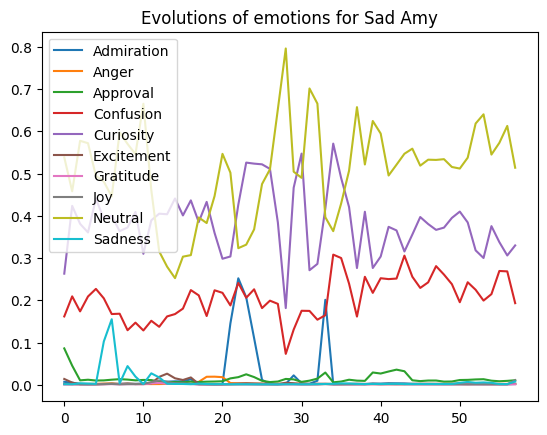

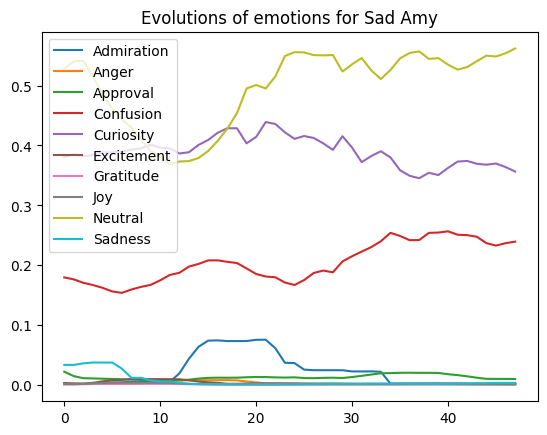

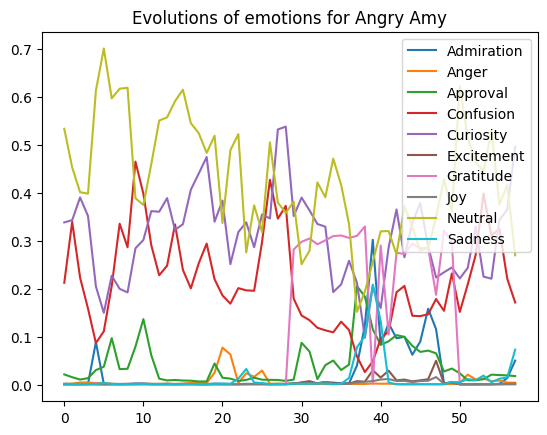

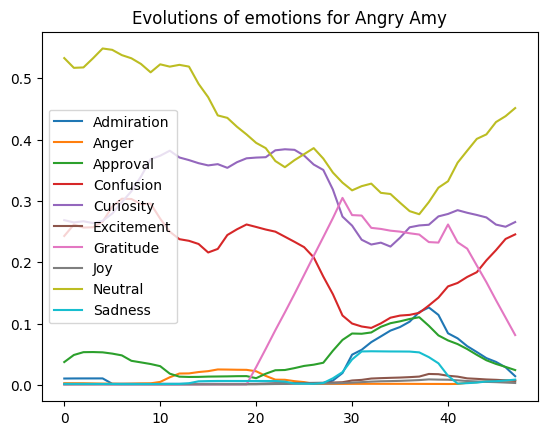

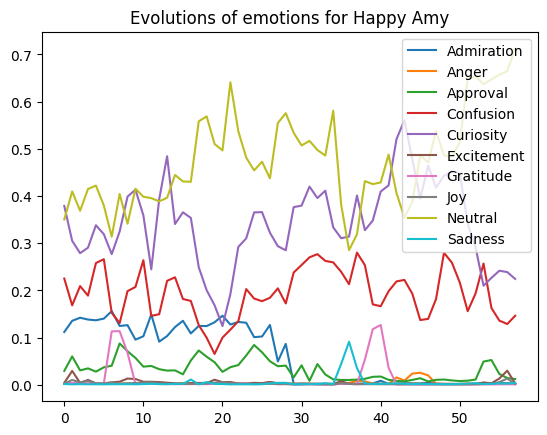

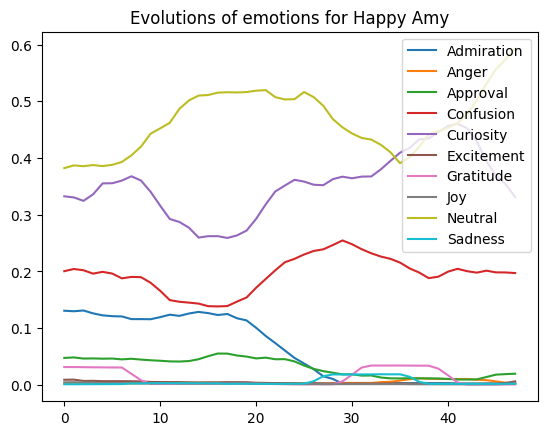

In [28]:
import matplotlib.pyplot as plt
import glob
# Plot full aggregate of emotions per emotion

emotions = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'neutral', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise']
filename = "./data/VG4R-Blackstories-convologs - Data.csv"
df = pd.read_csv(filename, sep=",")

NPC_emotions = []
score_filenames = glob.glob("data/results/*_roberta_wordwindow10_scores.pkl")
for score_filename in score_filenames:
    with open(score_filename, 'rb') as f:
        scores = pickle.load(f)
    if scores["middle_emotion"] not in NPC_emotions:
        NPC_emotions.append(scores["middle_emotion"])
print("Detected the following NPC emotions:", NPC_emotions)

aggregates_log = {}
for NPC_emotion in NPC_emotions:
    aggregated_scores = {
        "intro": np.zeros(28),
        "outro": np.zeros(28),
        "middle": np.zeros((n_values, 28)),
    }

    # Find the files that have the given emotion
    emotion_filenames = []
    for score_filename in score_filenames:
        with open(score_filename, 'rb') as f:
            scores = pickle.load(f)
        if scores["middle_emotion"] == NPC_emotion:
            emotion_filenames.append(score_filename)

    aggregated_scores = compute_score_aggregate(emotion_filenames)
    aggregates_log[NPC_emotion] = aggregated_scores

    plt.figure()
    plt.title(f"Evolution of emotions for {NPC_emotion.capitalize()} Amy")
    for emotion in chosen_difference_emotions:
        plt.plot(aggregated_scores["middle"][:, emotions.index(emotion.lower())], label=f"{emotion.capitalize()}")
    plt.legend()
    plt.savefig(f"data/results/plots/roberta_wordwindow10_{NPC_emotion}_chosen.png")
    plt.show()

    # Smoothen aggregates
    smoothing_window = 10
    smooth_aggregated_scores = {
        k: np.apply_along_axis(lambda m: np.convolve(m, np.ones(smoothing_window)/smoothing_window, mode='same'), 0, v)[smoothing_window//2:-smoothing_window//2]
        for k, v in aggregated_scores.items()
    }

    # plot it
    plt.figure()
    plt.title(f"Evolution of emotions for {NPC_emotion.capitalize()} Amy")
    for emotion in chosen_difference_emotions:
        plt.plot(smooth_aggregated_scores["middle"][:, emotions.index(emotion.lower())], label=f"{emotion.capitalize()}")
    plt.legend()
    plt.savefig(f"data/results/plots/roberta_wordwindow10_{NPC_emotion}_chosen_smoothed.png")
    plt.show()


(58, 28)


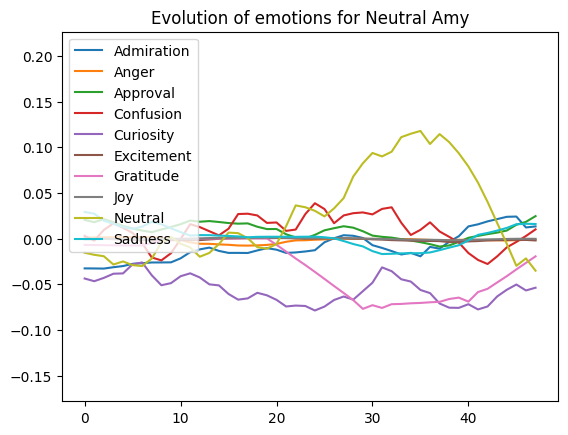

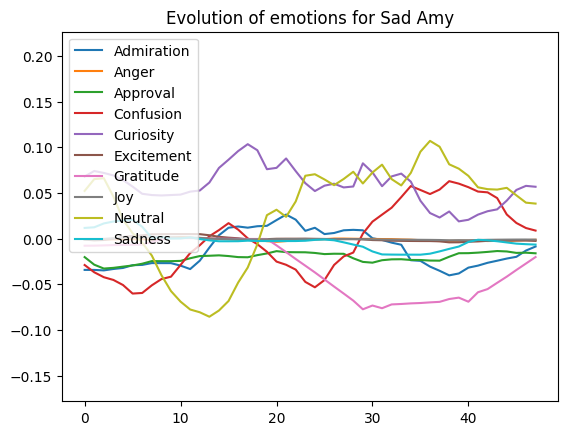

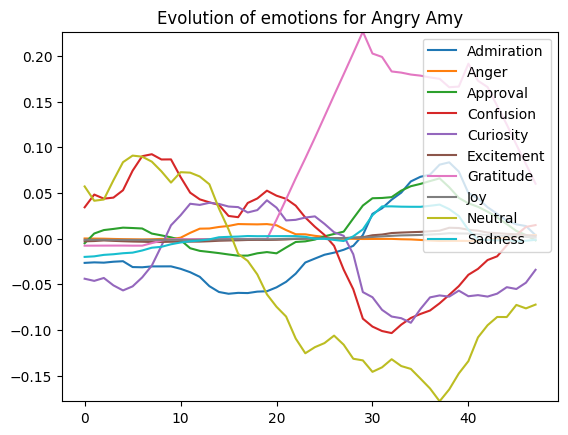

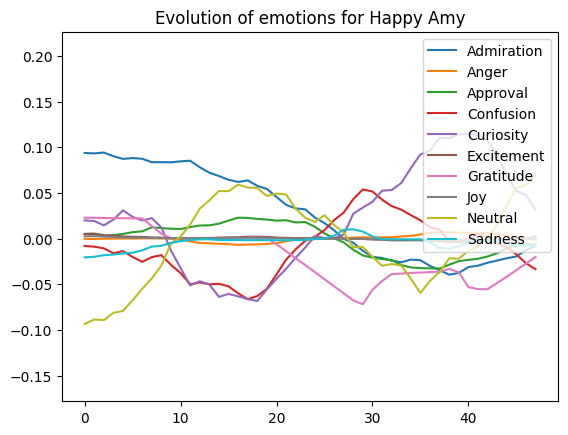

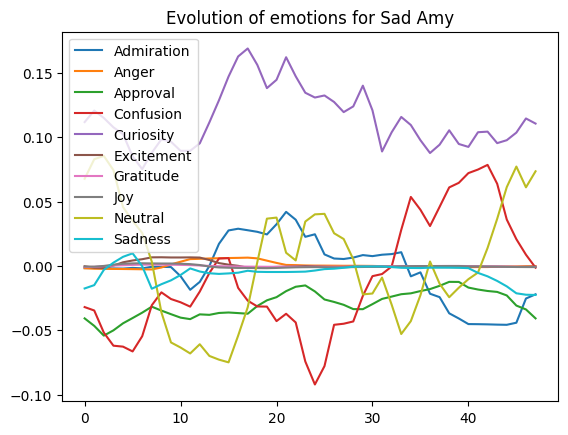

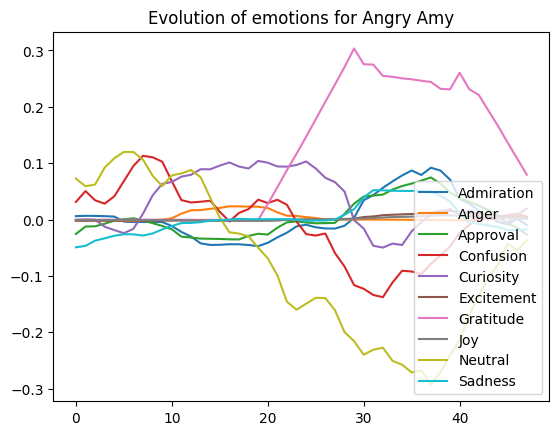

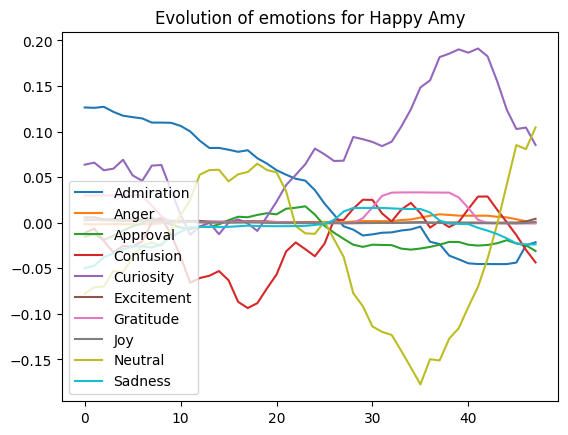

In [51]:
# Normalize scores
aggregates_log_mean = np.mean([aggregates_log[em]["middle"] for em in NPC_emotions], axis=0)
print(aggregates_log_mean.shape)

nms_perNPC = {}
for NPC_emotion in NPC_emotions:

    normalized_middle_scores_per_NPC = aggregates_log[NPC_emotion]["middle"] - aggregates_log_mean

    # Smoothen
    smoothing_window = 10
    smoothed_normalized_scores = np.apply_along_axis(lambda m: np.convolve(m, np.ones(smoothing_window)/smoothing_window, mode='same'), 0, normalized_middle_scores_per_NPC)[smoothing_window//2:-smoothing_window//2]

    nms_perNPC[NPC_emotion] = smoothed_normalized_scores

y_max = np.max([np.max(nms_perNPC[NPC_emotion]) for NPC_emotion in NPC_emotions])
y_min = np.min([np.min(nms_perNPC[NPC_emotion]) for NPC_emotion in NPC_emotions])

for NPC_emotion in NPC_emotions:

    smoothed_normalized_scores = nms_perNPC[NPC_emotion]

    # plot it
    plt.figure()
    plt.title(f"Evolution of emotions for {NPC_emotion.capitalize()} Amy")
    for emotion in chosen_difference_emotions:
        plt.plot(smoothed_normalized_scores[:, emotions.index(emotion.lower())], label=f"{emotion.capitalize()}")
    ax = plt.gca()
    ax.set_ylim([y_min, y_max])
    plt.legend()
    plt.savefig(f"data/results/plots/roberta_wordwindow10_{NPC_emotion}_chosen_smoothed_normalized.png")
    plt.show()

for NPC_emotion in NPC_emotions:
    if NPC_emotion == "neutral":
        continue

    netural_normalized_middle_scores = aggregates_log[NPC_emotion]["middle"] - aggregates_log["neutral"]["middle"]

    # Smoothen
    smoothing_window = 10
    smoothed_normalized_scores = np.apply_along_axis(lambda m: np.convolve(m, np.ones(smoothing_window)/smoothing_window, mode='same'), 0, netural_normalized_middle_scores)[smoothing_window//2:-smoothing_window//2]

    # plot it
    plt.figure()
    plt.title(f"Evolution of emotions for {NPC_emotion.capitalize()} Amy")
    for emotion in chosen_difference_emotions:
        plt.plot(smoothed_normalized_scores[:, emotions.index(emotion.lower())], label=f"{emotion.capitalize()}")
    plt.legend()
    plt.savefig(f"data/results/plots/roberta_wordwindow10_{NPC_emotion}_chosen_smoothed_neutralnormalized.png")
    plt.show()

In [49]:
npc_emotion_average = {}
for NPC_emotion in NPC_emotions:
    npc_emotion_average[NPC_emotion.capitalize()] = aggregates_log[NPC_emotion]["middle"].mean(axis=0)
df = pd.DataFrame.from_dict(npc_emotion_average) * 100
df.index = [e.capitalize() for e in emotions]
pd.set_option('display.float_format', '{:.1f}'.format)

style_cmap_diverging = 'vlag'
style_cmap_sequential = 'Blues'

full_scores_horizontal = df.T
# Remove average from all columns
#full_scores_horizontal = full_scores_horizontal - full_scores_horizontal.mean(axis=0)
full_scores_hm = full_scores_horizontal.style.background_gradient(cmap=style_cmap_sequential)
display(full_scores_hm)

full_scores_hm = df.style.background_gradient(cmap=style_cmap_diverging)
display(full_scores_hm)

chosen_emotions = ["Admiration", "Anger", "Approval", "Confusion", "Curiosity", "Excitement", "Gratitude", "Joy", "Neutral", "Sadness"]
emotion_scores_chosen = df.filter(items=chosen_emotions, axis=0)
emotion_scores_chosen_hm = emotion_scores_chosen.style.background_gradient(cmap=style_cmap_sequential)
display(emotion_scores_chosen_hm)

with open(f"data/results/npc_emotion_scores_chosen.html", "w") as f:
    f.write(emotion_scores_chosen_hm.to_html())


# Normalized tables
npc_emotion_average_normalized = {}
for NPC_emotion in NPC_emotions:
    npc_emotion_average_normalized[NPC_emotion.capitalize()] = aggregates_log[NPC_emotion]["middle"].mean(axis=0) - aggregates_log_mean.mean(axis=0)

df = pd.DataFrame.from_dict(npc_emotion_average_normalized) * 100
df.index = [e.capitalize() for e in emotions]
pd.set_option('display.float_format', '{:.1f}'.format)

style_cmap_diverging = 'vlag'
style_cmap_sequential = 'Blues'

full_scores_hm = df.style.background_gradient(cmap=style_cmap_diverging)
display(full_scores_hm)

chosen_emotions = ["Admiration", "Anger", "Approval", "Confusion", "Curiosity", "Excitement", "Gratitude", "Joy", "Neutral", "Sadness"]
emotion_scores_chosen = df.filter(items=chosen_emotions, axis=0)

#def my_format(val):
#    return f"{val:,.2f}"
#dict_format = {e: my_format for e in chosen_emotions}

emotion_scores_chosen_hm = emotion_scores_chosen.style.background_gradient(cmap=style_cmap_sequential)
#emotion_scores_chosen_hm.format(dict_format)
display(emotion_scores_chosen_hm)

with open(f"data/results/npc_emotion_scores_chosen_normalized.html", "w") as f:
    f.write(emotion_scores_chosen_hm.to_html())

# Neutral normalized tables
npc_emotion_average_netural_normalized = {}
for NPC_emotion in NPC_emotions:
    if NPC_emotion == "neutral":
        continue
    npc_emotion_average_netural_normalized[NPC_emotion.capitalize()] = aggregates_log[NPC_emotion]["middle"].mean(axis=0) - aggregates_log["neutral"]["middle"].mean(axis=0)

df = pd.DataFrame.from_dict(npc_emotion_average_netural_normalized) * 100
df.index = [e.capitalize() for e in emotions]

style_cmap_diverging = 'vlag'
style_cmap_sequential = 'Blues'

full_scores_hm = df.style.background_gradient(cmap=style_cmap_diverging)
display(full_scores_hm)

chosen_emotions = ["Admiration", "Anger", "Approval", "Confusion", "Curiosity", "Excitement", "Gratitude", "Joy", "Neutral", "Sadness"]
emotion_scores_chosen = df.filter(items=chosen_emotions, axis=0)
emotion_scores_chosen_hm = emotion_scores_chosen.style.background_gradient(cmap=style_cmap_sequential)
display(emotion_scores_chosen_hm)

with open(f"data/results/npc_emotion_scores_chosen_neutralnormalized.html", "w") as f:
    f.write(emotion_scores_chosen_hm.to_html())

,Admiration,Amusement,Anger,Annoyance,Approval,Caring,Confusion,Curiosity,Desire,Disappointment,Disapproval,Disgust,Embarrassment,Excitement,Fear,Gratitude,Grief,Joy,Love,Nervousness,Neutral,Optimism,Pride,Realization,Relief,Remorse,Sadness,Surprise
Neutral,2.163227,0.184487,0.247630,1.298997,4.652242,0.537273,22.084037,26.839083,0.271293,1.902148,2.558856,0.182177,0.173344,0.285227,0.585350,0.142967,0.094454,0.192585,1.250917,0.241170,49.340720,0.670274,0.044366,1.944583,0.066513,2.203214,1.739751,0.695033
Sad,1.899773,0.208776,0.297549,1.234932,1.433885,0.182411,20.557098,38.383628,0.140354,0.422153,0.780517,0.149915,0.107845,0.355351,0.140965,0.111449,0.073085,0.175073,0.210279,0.065508,50.612816,0.361058,0.023128,1.297138,0.044462,0.076608,0.826330,2.740937
Angry,2.670061,0.184437,0.702160,2.450550,4.287381,0.866239,21.350350,30.972432,0.241179,0.585829,3.141769,0.191000,0.112978,0.473673,0.174271,9.828352,0.088004,0.275520,0.191224,0.125529,42.480987,0.470002,0.040322,1.111141,0.097061,0.134826,1.405719,0.614637
Happy,6.181260,0.216735,0.413397,1.275252,3.181126,0.264849,19.401604,34.210387,0.337513,0.571952,1.601005,0.158878,0.094023,0.501507,0.166799,1.229085,0.045735,0.260068,1.896687,0.104557,47.632854,0.765253,0.028434,0.918607,0.041083,0.510772,0.498649,0.834427


,Neutral,Sad,Angry,Happy
Admiration,2.163227,1.899773,2.670061,6.181260
Amusement,0.184487,0.208776,0.184437,0.216735
Anger,0.247630,0.297549,0.702160,0.413397
Annoyance,1.298997,1.234932,2.450550,1.275252
Approval,4.652242,1.433885,4.287381,3.181126
Caring,0.537273,0.182411,0.866239,0.264849
Confusion,22.084037,20.557098,21.350350,19.401604
Curiosity,26.839083,38.383628,30.972432,34.210387
Desire,0.271293,0.140354,0.241179,0.337513
Disappointment,1.902148,0.422153,0.585829,0.571952


,Neutral,Sad,Angry,Happy
Admiration,2.163227,1.899773,2.670061,6.181260
Anger,0.247630,0.297549,0.702160,0.413397
Approval,4.652242,1.433885,4.287381,3.181126
Confusion,22.084037,20.557098,21.350350,19.401604
Curiosity,26.839083,38.383628,30.972432,34.210387
Excitement,0.285227,0.355351,0.473673,0.501507
Gratitude,0.142967,0.111449,9.828352,1.229085
Joy,0.192585,0.175073,0.275520,0.260068
Neutral,49.340720,50.612816,42.480987,47.632854
Sadness,1.739751,0.826330,1.405719,0.498649


,Neutral,Sad,Angry,Happy
Admiration,-1.065353,-1.328807,-0.558519,2.952680
Amusement,-0.014122,0.010167,-0.014172,0.018126
Anger,-0.167554,-0.117635,0.286976,-0.001787
Annoyance,-0.265936,-0.330001,0.885618,-0.289681
Approval,1.263584,-1.954773,0.898722,-0.207533
Caring,0.074580,-0.280282,0.403546,-0.197844
Confusion,1.235765,-0.291174,0.502078,-1.446669
Curiosity,-5.762300,5.782245,-1.628950,1.609005
Desire,0.023708,-0.107230,-0.006406,0.089928
Disappointment,1.031627,-0.448368,-0.284691,-0.298568


,Neutral,Sad,Angry,Happy
Admiration,-1.065353,-1.328807,-0.558519,2.952680
Anger,-0.167554,-0.117635,0.286976,-0.001787
Approval,1.263584,-1.954773,0.898722,-0.207533
Confusion,1.235765,-0.291174,0.502078,-1.446669
Curiosity,-5.762300,5.782245,-1.628950,1.609005
Excitement,-0.118712,-0.048588,0.069733,0.097567
Gratitude,-2.684996,-2.716514,7.000389,-1.598879
Joy,-0.033226,-0.050739,0.049709,0.034257
Neutral,1.823876,3.095972,-5.035857,0.116010
Sadness,0.622139,-0.291282,0.288107,-0.618963


,Sad,Angry,Happy
Admiration,-0.263454,0.506834,4.018033
Amusement,0.024289,-0.000050,0.032247
Anger,0.049919,0.454530,0.165767
Annoyance,-0.064065,1.151554,-0.023745
Approval,-3.218357,-0.364862,-1.471117
Caring,-0.354862,0.328965,-0.272425
Confusion,-1.526940,-0.733687,-2.682434
Curiosity,11.544545,4.133349,7.371305
Desire,-0.130938,-0.030114,0.066220
Disappointment,-1.479995,-1.316318,-1.330195


,Sad,Angry,Happy
Admiration,-0.263454,0.506834,4.018033
Anger,0.049919,0.454530,0.165767
Approval,-3.218357,-0.364862,-1.471117
Confusion,-1.526940,-0.733687,-2.682434
Curiosity,11.544545,4.133349,7.371305
Excitement,0.070124,0.188445,0.216279
Gratitude,-0.031518,9.685385,1.086118
Joy,-0.017512,0.082935,0.067483
Neutral,1.272096,-6.859733,-1.707866
Sadness,-0.913421,-0.334031,-1.241102


In [30]:
chosen_difference_emotions = ["Admiration", "Anger", "Approval", "Confusion", "Curiosity", "Excitement", "Gratitude", "Joy", "Neutral", "Sadness"]

for NPC_emotion in NPC_emotions:
    aggregated_scores = aggregates_log[NPC_emotion]
    compute_tables(aggregated_scores, title_prefix=f"{NPC_emotion}_")
    #plt.figure()
    #plt.title(f"Evolution of emotions for {NPC_emotion.capitalize()} Amy")
    #for emotion in chosen_difference_emotions:
    #    plt.plot(aggregated_scores["middle"][:, emotions.index(emotion.lower())], label=f"{emotion.capitalize()}")
    #plt.legend()
    #plt.show()

,Intro,Gameplay,Outro,Total impact,Gameplay impact,Outro impact
Admiration,3.7,2.2,9.3,5.6,-1.5,7.1
Amusement,0.3,0.2,0.3,-0.0,-0.2,0.1
Anger,0.2,0.2,0.3,0.1,0.0,0.1
Annoyance,1.1,1.3,2.7,1.5,0.2,1.4
Approval,13.7,4.7,11.1,-2.6,-9.0,6.5
Caring,0.6,0.5,0.7,0.1,-0.1,0.2
Confusion,9.2,22.1,15.3,6.1,12.9,-6.8
Curiosity,20.5,26.8,4.5,-16.0,6.3,-22.3
Desire,0.8,0.3,0.3,-0.5,-0.5,-0.0
Disappointment,0.4,1.9,3.3,2.9,1.5,1.4


,Intro,Gameplay,Outro,Total impact,Gameplay impact,Outro impact
Admiration,3.695931,2.163227,9.250385,5.554454,-1.532704,7.087158
Amusement,0.341418,0.184487,0.320408,-0.021010,-0.156931,0.135921
Anger,0.204997,0.247630,0.334341,0.129344,0.042633,0.086711
Annoyance,1.132071,1.298997,2.663670,1.531600,0.166926,1.364674
Approval,13.700463,4.652242,11.146784,-2.553678,-9.048220,6.494542
Caring,0.597743,0.537273,0.721386,0.123642,-0.060470,0.184112
Confusion,9.211575,22.084037,15.308298,6.096723,12.872462,-6.775740
Curiosity,20.520456,26.839083,4.549340,-15.971116,6.318627,-22.289742
Desire,0.775923,0.271293,0.265807,-0.510116,-0.504630,-0.005485
Disappointment,0.407671,1.902148,3.264179,2.856508,1.494476,1.362031


,Intro,Gameplay,Outro
Admiration,3.695931,2.163227,9.250385
Amusement,0.341418,0.184487,0.320408
Anger,0.204997,0.247630,0.334341
Annoyance,1.132071,1.298997,2.663670
Approval,13.700463,4.652242,11.146784
Caring,0.597743,0.537273,0.721386
Confusion,9.211575,22.084037,15.308298
Curiosity,20.520456,26.839083,4.549340
Desire,0.775923,0.271293,0.265807
Disappointment,0.407671,1.902148,3.264179


,Total impact,Gameplay impact,Outro impact
Admiration,5.554454,-1.532704,7.087158
Amusement,-0.021010,-0.156931,0.135921
Anger,0.129344,0.042633,0.086711
Annoyance,1.531600,0.166926,1.364674
Approval,-2.553678,-9.048220,6.494542
Caring,0.123642,-0.060470,0.184112
Confusion,6.096723,12.872462,-6.775740
Curiosity,-15.971116,6.318627,-22.289742
Desire,-0.510116,-0.504630,-0.005485
Disappointment,2.856508,1.494476,1.362031


,Intro,Gameplay,Outro
Admiration,3.695931,2.163227,9.250385
Anger,0.204997,0.247630,0.334341
Approval,13.700463,4.652242,11.146784
Confusion,9.211575,22.084037,15.308298
Curiosity,20.520456,26.839083,4.549340
Excitement,4.161709,0.285227,0.525093
Gratitude,0.189597,0.142967,5.439554
Joy,3.218274,0.192585,3.285141
Neutral,44.857494,49.340720,38.790857
Sadness,0.171949,1.739751,6.902532


,Total impact,Gameplay impact,Outro impact
Admiration,5.554454,-1.532704,7.087158
Anger,0.129344,0.042633,0.086711
Approval,-2.553678,-9.048220,6.494542
Confusion,6.096723,12.872462,-6.775740
Curiosity,-15.971116,6.318627,-22.289742
Excitement,-3.636616,-3.876482,0.239866
Gratitude,5.249957,-0.046630,5.296587
Joy,0.066867,-3.025689,3.092556
Neutral,-6.066637,4.483226,-10.549863
Sadness,6.730583,1.567802,5.162781


,Intro,Gameplay,Outro,Total impact,Gameplay impact,Outro impact
Admiration,2.2,1.9,3.9,1.6,-0.3,2.0
Amusement,0.9,0.2,0.2,-0.7,-0.7,-0.0
Anger,0.1,0.3,0.4,0.3,0.2,0.1
Annoyance,0.5,1.2,3.0,2.5,0.7,1.8
Approval,25.1,1.4,10.3,-14.8,-23.7,8.9
Caring,4.8,0.2,0.2,-4.6,-4.6,0.1
Confusion,1.8,20.6,2.1,0.4,18.8,-18.4
Curiosity,4.6,38.4,4.5,-0.1,33.8,-33.9
Desire,0.4,0.1,0.3,-0.1,-0.3,0.1
Disappointment,0.2,0.4,2.2,2.1,0.2,1.8


,Intro,Gameplay,Outro,Total impact,Gameplay impact,Outro impact
Admiration,2.243943,1.899773,3.884409,1.640467,-0.344170,1.984636
Amusement,0.865834,0.208776,0.193171,-0.672664,-0.657058,-0.015605
Anger,0.108533,0.297549,0.429471,0.320938,0.189015,0.131923
Annoyance,0.509281,1.234932,3.023891,2.514610,0.725651,1.788959
Approval,25.114657,1.433885,10.303196,-14.811461,-23.680772,8.869311
Caring,4.812233,0.182411,0.234340,-4.577893,-4.629822,0.051929
Confusion,1.751356,20.557098,2.108439,0.357083,18.805742,-18.448659
Curiosity,4.621201,38.383628,4.483175,-0.138027,33.762426,-33.900453
Desire,0.414012,0.140354,0.269727,-0.144286,-0.273658,0.129372
Disappointment,0.183629,0.422153,2.243897,2.060268,0.238523,1.821745


,Intro,Gameplay,Outro
Admiration,2.243943,1.899773,3.884409
Amusement,0.865834,0.208776,0.193171
Anger,0.108533,0.297549,0.429471
Annoyance,0.509281,1.234932,3.023891
Approval,25.114657,1.433885,10.303196
Caring,4.812233,0.182411,0.234340
Confusion,1.751356,20.557098,2.108439
Curiosity,4.621201,38.383628,4.483175
Desire,0.414012,0.140354,0.269727
Disappointment,0.183629,0.422153,2.243897


,Total impact,Gameplay impact,Outro impact
Admiration,1.640467,-0.344170,1.984636
Amusement,-0.672664,-0.657058,-0.015605
Anger,0.320938,0.189015,0.131923
Annoyance,2.514610,0.725651,1.788959
Approval,-14.811461,-23.680772,8.869311
Caring,-4.577893,-4.629822,0.051929
Confusion,0.357083,18.805742,-18.448659
Curiosity,-0.138027,33.762426,-33.900453
Desire,-0.144286,-0.273658,0.129372
Disappointment,2.060268,0.238523,1.821745


,Intro,Gameplay,Outro
Admiration,2.243943,1.899773,3.884409
Anger,0.108533,0.297549,0.429471
Approval,25.114657,1.433885,10.303196
Confusion,1.751356,20.557098,2.108439
Curiosity,4.621201,38.383628,4.483175
Excitement,1.380686,0.355351,0.855243
Gratitude,0.194614,0.111449,0.119990
Joy,1.027601,0.175073,0.481385
Neutral,62.855856,50.612816,46.799825
Sadness,0.132521,0.826330,1.664492


,Total impact,Gameplay impact,Outro impact
Admiration,1.640467,-0.344170,1.984636
Anger,0.320938,0.189015,0.131923
Approval,-14.811461,-23.680772,8.869311
Confusion,0.357083,18.805742,-18.448659
Curiosity,-0.138027,33.762426,-33.900453
Excitement,-0.525443,-1.025335,0.499891
Gratitude,-0.074624,-0.083165,0.008541
Joy,-0.546216,-0.852528,0.306312
Neutral,-16.056032,-12.243040,-3.812991
Sadness,1.531970,0.693808,0.838162


,Intro,Gameplay,Outro,Total impact,Gameplay impact,Outro impact
Admiration,5.6,2.7,0.4,-5.2,-3.0,-2.3
Amusement,0.8,0.2,0.2,-0.6,-0.6,0.0
Anger,0.1,0.7,0.3,0.2,0.6,-0.4
Annoyance,0.5,2.5,2.4,1.9,2.0,-0.1
Approval,23.7,4.3,4.1,-19.6,-19.4,-0.2
Caring,0.4,0.9,0.2,-0.1,0.5,-0.6
Confusion,4.6,21.4,37.6,33.1,16.8,16.3
Curiosity,24.7,31.0,7.3,-17.4,6.3,-23.7
Desire,0.6,0.2,3.0,2.3,-0.4,2.7
Disappointment,0.2,0.6,1.9,1.7,0.4,1.3


,Intro,Gameplay,Outro,Total impact,Gameplay impact,Outro impact
Admiration,5.649401,2.670061,0.413045,-5.236357,-2.979340,-2.257017
Amusement,0.812690,0.184437,0.228478,-0.584212,-0.628253,0.044041
Anger,0.143333,0.702160,0.315389,0.172056,0.558826,-0.386770
Annoyance,0.452857,2.450550,2.382497,1.929640,1.997694,-0.068054
Approval,23.695001,4.287381,4.080599,-19.614402,-19.407620,-0.206782
Caring,0.362327,0.866239,0.228683,-0.133644,0.503912,-0.637556
Confusion,4.556221,21.350350,37.618538,33.062317,16.794129,16.268188
Curiosity,24.661155,30.972432,7.288210,-17.372944,6.311277,-23.684222
Desire,0.634258,0.241179,2.964768,2.330509,-0.393079,2.723589
Disappointment,0.194134,0.585829,1.904122,1.709988,0.391695,1.318293


,Intro,Gameplay,Outro
Admiration,5.649401,2.670061,0.413045
Amusement,0.812690,0.184437,0.228478
Anger,0.143333,0.702160,0.315389
Annoyance,0.452857,2.450550,2.382497
Approval,23.695001,4.287381,4.080599
Caring,0.362327,0.866239,0.228683
Confusion,4.556221,21.350350,37.618538
Curiosity,24.661155,30.972432,7.288210
Desire,0.634258,0.241179,2.964768
Disappointment,0.194134,0.585829,1.904122


,Total impact,Gameplay impact,Outro impact
Admiration,-5.236357,-2.979340,-2.257017
Amusement,-0.584212,-0.628253,0.044041
Anger,0.172056,0.558826,-0.386770
Annoyance,1.929640,1.997694,-0.068054
Approval,-19.614402,-19.407620,-0.206782
Caring,-0.133644,0.503912,-0.637556
Confusion,33.062317,16.794129,16.268188
Curiosity,-17.372944,6.311277,-23.684222
Desire,2.330509,-0.393079,2.723589
Disappointment,1.709988,0.391695,1.318293


,Intro,Gameplay,Outro
Admiration,5.649401,2.670061,0.413045
Anger,0.143333,0.702160,0.315389
Approval,23.695001,4.287381,4.080599
Confusion,4.556221,21.350350,37.618538
Curiosity,24.661155,30.972432,7.288210
Excitement,4.873730,0.473673,0.352505
Gratitude,16.474459,9.828352,0.485078
Joy,11.122495,0.275520,0.374658
Neutral,12.840101,42.480987,43.733623
Sadness,0.140176,1.405719,0.331709


,Total impact,Gameplay impact,Outro impact
Admiration,-5.236357,-2.979340,-2.257017
Anger,0.172056,0.558826,-0.386770
Approval,-19.614402,-19.407620,-0.206782
Confusion,33.062317,16.794129,16.268188
Curiosity,-17.372944,6.311277,-23.684222
Excitement,-4.521225,-4.400057,-0.121168
Gratitude,-15.989380,-6.646107,-9.343273
Joy,-10.747837,-10.846975,0.099137
Neutral,30.893522,29.640886,1.252636
Sadness,0.191533,1.265544,-1.074010


,Intro,Gameplay,Outro,Total impact,Gameplay impact,Outro impact
Admiration,8.2,6.2,4.0,-4.1,-2.0,-2.1
Amusement,0.3,0.2,0.9,0.5,-0.1,0.7
Anger,0.2,0.4,0.4,0.2,0.2,0.0
Annoyance,0.6,1.3,4.3,3.6,0.7,3.0
Approval,9.3,3.2,11.7,2.4,-6.1,8.5
Caring,0.3,0.3,0.8,0.5,-0.0,0.5
Confusion,3.5,19.4,8.7,5.2,15.9,-10.7
Curiosity,16.2,34.2,11.3,-4.9,18.0,-22.9
Desire,0.4,0.3,4.9,4.5,-0.1,4.6
Disappointment,0.3,0.6,7.0,6.7,0.3,6.4


,Intro,Gameplay,Outro,Total impact,Gameplay impact,Outro impact
Admiration,8.172399,6.181260,4.044027,-4.128372,-1.991139,-2.137233
Amusement,0.339801,0.216735,0.887493,0.547692,-0.123066,0.670758
Anger,0.204962,0.413397,0.430142,0.225180,0.208435,0.016745
Annoyance,0.619290,1.275252,4.260574,3.641285,0.655962,2.985323
Approval,9.262169,3.181126,11.656103,2.393935,-6.081043,8.474978
Caring,0.306853,0.264849,0.802133,0.495281,-0.042004,0.537285
Confusion,3.505020,19.401604,8.668643,5.163622,15.896583,-10.732961
Curiosity,16.187578,34.210387,11.295079,-4.892499,18.022809,-22.915308
Desire,0.398154,0.337513,4.925728,4.527574,-0.060641,4.588215
Disappointment,0.319330,0.571952,7.003438,6.684108,0.252622,6.431486


,Intro,Gameplay,Outro
Admiration,8.172399,6.181260,4.044027
Amusement,0.339801,0.216735,0.887493
Anger,0.204962,0.413397,0.430142
Annoyance,0.619290,1.275252,4.260574
Approval,9.262169,3.181126,11.656103
Caring,0.306853,0.264849,0.802133
Confusion,3.505020,19.401604,8.668643
Curiosity,16.187578,34.210387,11.295079
Desire,0.398154,0.337513,4.925728
Disappointment,0.319330,0.571952,7.003438


,Total impact,Gameplay impact,Outro impact
Admiration,-4.128372,-1.991139,-2.137233
Amusement,0.547692,-0.123066,0.670758
Anger,0.225180,0.208435,0.016745
Annoyance,3.641285,0.655962,2.985323
Approval,2.393935,-6.081043,8.474978
Caring,0.495281,-0.042004,0.537285
Confusion,5.163622,15.896583,-10.732961
Curiosity,-4.892499,18.022809,-22.915308
Desire,4.527574,-0.060641,4.588215
Disappointment,6.684108,0.252622,6.431486


,Intro,Gameplay,Outro
Admiration,8.172399,6.181260,4.044027
Anger,0.204962,0.413397,0.430142
Approval,9.262169,3.181126,11.656103
Confusion,3.505020,19.401604,8.668643
Curiosity,16.187578,34.210387,11.295079
Excitement,5.695926,0.501507,0.768603
Gratitude,0.187655,1.229085,2.471842
Joy,2.918179,0.260068,1.142857
Neutral,30.599215,47.632854,41.085989
Sadness,0.208402,0.498649,1.881519


,Total impact,Gameplay impact,Outro impact
Admiration,-4.128372,-1.991139,-2.137233
Anger,0.225180,0.208435,0.016745
Approval,2.393935,-6.081043,8.474978
Confusion,5.163622,15.896583,-10.732961
Curiosity,-4.892499,18.022809,-22.915308
Excitement,-4.927322,-5.194419,0.267097
Gratitude,2.284188,1.041430,1.242758
Joy,-1.775322,-2.658111,0.882789
Neutral,10.486773,17.033639,-6.546866
Sadness,1.673118,0.290247,1.382871


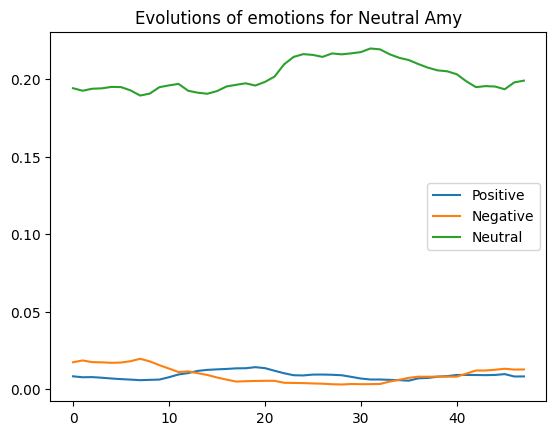

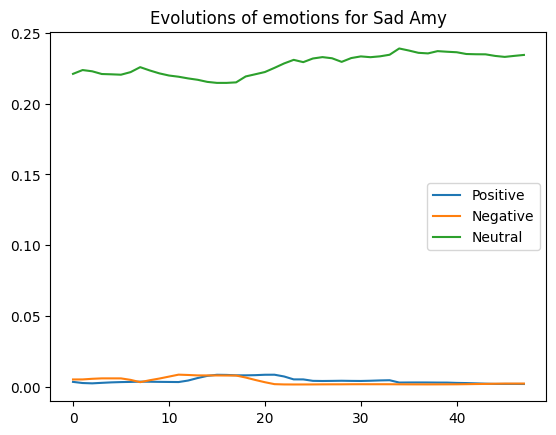

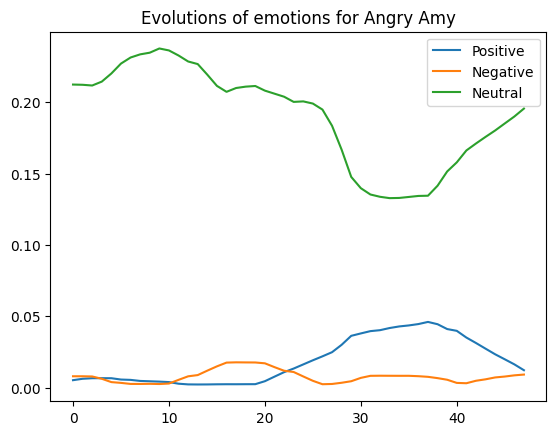

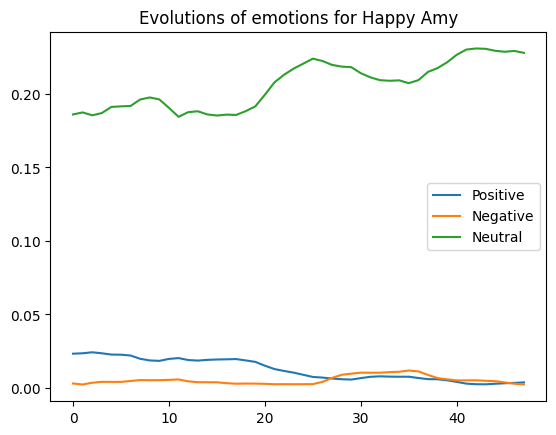

In [31]:
import pickle

# For each npc plot positivity negativity neutrality
positive_emotions = ["admiration", "amusement", "approval", "caring", "desire", "excitement", "gratitude", "joy", "love", "optimism", "pride", "relief"]
negative_emotions = ["anger", "annoyance", "disappointment", "disapproval", "disgust", "embarrassment", "fear", "grief", "nervousness", "remorse", "sadness"]
neutral_emotions = ["confusion", "curiosity", "realization", "neutral", "surprise"]

scores_pos_neg_neutral = {}
for NPC_emotion in NPC_emotions:
    aggregated_scores = aggregates_log[NPC_emotion]
    # Compute positivity, negativity, neutrality
    positive_scores = aggregated_scores["middle"][:, [emotions.index(e) for e in positive_emotions]].mean(axis=1)
    negative_scores = aggregated_scores["middle"][:, [emotions.index(e) for e in negative_emotions]].mean(axis=1)
    neutral_scores = aggregated_scores["middle"][:, [emotions.index(e) for e in neutral_emotions]].mean(axis=1)
    scores_pos_neg_neutral[NPC_emotion] = {
        "Positive": positive_scores,
        "Negative": negative_scores,
        "Neutral": neutral_scores,
    }

    pickle.dump(scores_pos_neg_neutral, open("data/results/scores_pos_neg_neutral.pkl", "wb"))

    # Smoothen aggregates
    smoothing_window = 10
    smooth_aggregated_scores = {
        k: np.apply_along_axis(lambda m: np.convolve(m, np.ones(smoothing_window)/smoothing_window, mode='same'), 0, v)[smoothing_window//2:-smoothing_window//2]
        for k, v in scores_pos_neg_neutral[NPC_emotion].items()
    }

    plt.figure()
    plt.title(f"Evolution of emotions for {NPC_emotion.capitalize()} Amy")
    for emotion in ["Positive", "Negative", "Neutral"]:
        plt.plot(smooth_aggregated_scores[emotion], label=f"{emotion.capitalize()}")
    plt.legend()
    plt.savefig(f"data/results/plots/roberta_wordwindow10_{NPC_emotion}_pos_neg_neutral_smoothed.png")
    plt.show()